<center><big><b>SegPore for Inosine Identification</b></big></center>

After the training on IVT data, we divide 81 XXAXX (X is A, C, or U/T) into three patterns. 
- Pattern 1: 5mers that show no difference  between A and I;
- Pattern 2: 5mers that show significant difference between A and I;
- Pattern 3: 5mers that show significant difference between A and I, but the component weight of A is low. 

In [1]:
from matplotlib import rcParams
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.stats import norm
import os

model_kmer = pd.read_csv("model_kmer_A_to_I.csv")
for i in [1, 2, 3]:
    model_kmer_pattern = model_kmer[model_kmer['pattern'] == i]
    print(f"Pattern {i}: 5mer count {len(model_kmer_pattern)}.")

Pattern 1: 5mer count 20.
Pattern 2: 5mer count 23.
Pattern 3: 5mer count 38.


In [2]:
print(model_kmer)

     model_kmer  model_mean  model_stdv  model_mean_mod  model_stdv_mod  \
0         AAAAA      108.90        2.16          116.85            3.00   
1         AAAAC      107.75        2.68          119.91            3.00   
2         AAAAG      101.72        2.68          101.72            2.68   
3         AAAAT      112.77        2.68          123.53            2.00   
4         AAACA       99.38        1.78          106.19            2.89   
...         ...         ...         ...             ...             ...   
1020      TTTGT       85.15        2.65           85.15            2.65   
1021      TTTTA       79.28        1.97           79.28            1.97   
1022      TTTTC       77.91        1.97           77.91            1.97   
1023      TTTTG       81.03        1.97           81.03            1.97   
1024      TTTTT       80.78        1.97           80.78            1.97   

      pattern   diff  
0           2   7.95  
1           3  12.16  
2           0   0.00  
3      

In [3]:
def read_model_kmer(file_name="model_kmer.csv"):
    """
    Read model kmer and return a dict.
    :param file_name:
    :return:
    """
    model_kmer_pd = pd.read_csv(file_name, sep=',').to_dict('records')
    model_kmer_dict = dict()
    for item in model_kmer_pd:
        model_kmer_dict[item['model_kmer']] = item
    return model_kmer_dict

model_kmer_dict = read_model_kmer("model_kmer_A_to_I.csv")

In [4]:
pattern_1_example_kmers = ['AAGCC', 'AAGTC', 'ACGTT', 'CCGTT', 'CTGTT']
pattern_2_example_kmers = ['ATGTT', 'CCGAT', 'TAGTT', 'TCGTC', 'TTGTA']
pattern_3_example_kmers = ['ATGCA', 'CAGCA', 'CCGCC', 'CTGAA', 'TCGAC']

In [5]:
def subplot_for_G(plot_center_mu=90.00, _mu=90.00, _sigma=2.0, _w=1.0, line=True):
    plot_x_arr = np.linspace(_mu - 3 * _sigma, _mu + 3 * _sigma)
    plt.plot(plot_x_arr, _w * norm.pdf(plot_x_arr, _mu, _sigma), color="black")

    if line:
        plt.axvline(x=_mu,  ls='--', color="black")

    plt.ylim((0, 0.20))
    plt.xlim((plot_center_mu - 25, plot_center_mu + 25))
    
    
def subplot_for_A_and_I(plot_center_mu=90.00, _mu_A=90.00, _sigma_A=2.0, _w_A=1.0, _mu_I=90.00,
                        _sigma_I=2.0, _w_I=1.0, pattern=1):

    plt.axvline(x=_mu_A, ls='--', color="black")
    plot_x_arr = np.linspace(_mu_A - 3 * _sigma_A, _mu_A + 3 * _sigma_A)
    if pattern == 2:
        plt.plot(plot_x_arr, _w_A * norm.pdf(plot_x_arr, _mu_A, _sigma_A), color="red")
    else:
        plt.plot(plot_x_arr, _w_A * norm.pdf(plot_x_arr, _mu_A, _sigma_A), color="black")
    
    if pattern != 1:
        plt.axvline(x=_mu_I, ls='--', color="red")
        plot_x_arr = np.linspace(_mu_I - 3 * _sigma_I, _mu_I + 3 * _sigma_I)
        plt.plot(plot_x_arr, _w_I * norm.pdf(plot_x_arr, _mu_I, _sigma_I), color="red")

    plt.ylim((0, 0.20))
    plt.xlim((plot_center_mu - 25, plot_center_mu + 25))


def plot_exmaple_kmers(kmer_lists, pattern):
    
    plt.figure(figsize=(13, 4.3))
    pal_ori = sns.color_palette("pastel")
    if pattern == 1:
        my_palette=[pal_ori[1]]
    elif pattern == 2:
        my_palette=[pal_ori[0]] + [pal_ori[1]]
    else:
        my_palette=[pal_ori[3]]
    
    idx = 1
    for G_kmer in kmer_lists:
        
        A_kmer = G_kmer[0:2] + "A" + G_kmer[3:5]
        title = G_kmer[0:2] + "H" + G_kmer[3:5]
    
        mu_G = model_kmer_dict[G_kmer]["model_mean"]
        sigma_G = model_kmer_dict[G_kmer]["model_stdv"]

        mu_A = model_kmer_dict[A_kmer]["model_mean"]
        sigma_A = model_kmer_dict[A_kmer]["model_stdv"]
        
        mu_I = model_kmer_dict[A_kmer]["model_mean_mod"]
        sigma_I = model_kmer_dict[A_kmer]["model_stdv_mod"]
        
        def get_label(x):
            if norm.logpdf(x, loc=mu_A, scale=sigma_A) > norm.logpdf(x, loc=mu_I,scale=sigma_I):
                return 1
            else:
                return 2
        
        my_G_data = pd.read_csv(os.path.join("ivt_data", G_kmer, "pureG.csv"))
        my_G_data['label'] = 0
        
        my_I_data = pd.read_csv(os.path.join("ivt_data", G_kmer, "pureI.csv"))
        if pattern == 1:
            plot_center = mu_A
            my_I_data['label'] = 3
            _w_A = 1.0
            _w_I = 1.0
        elif pattern == 2:
            plot_center = mu_I
            my_I_data['label'] = my_I_data['mean'].apply(lambda x: get_label(x))
            _w_A = len(my_I_data[my_I_data['label'] == 1]) / len(my_I_data)
            _w_I = 1.0 - _w_A
        else:
            plot_center = mu_I
            my_I_data['label'] = 3
            _w_A = 1.0
            _w_I = 1.0
            
        ax1 = plt.subplot(2, 5, idx)
        ax1_1 = sns.kdeplot(
                data=my_G_data, x="mean", hue="label",
                fill=True, common_norm=True, palette=[pal_ori[2]],
                alpha=.5, linewidth=1.0, legend=False
            )
        ax1_1.set_xlabel("")
        ax1_1.set_ylabel("")
        subplot_for_G(plot_center_mu=plot_center, _mu=mu_G, _sigma=sigma_G)
        plt.title(title, fontsize=12)

        ax2 = plt.subplot(2, 5, idx+5)
        ax2_1 = sns.kdeplot(
                data=my_I_data, x="mean", hue="label",
                fill=True, common_norm=True, palette=my_palette,
                alpha=.5, linewidth=1.0, legend=False
            )
        ax2_1.set_xlabel("")
        ax2_1.set_ylabel("")
        subplot_for_A_and_I(plot_center_mu=plot_center, 
                            _mu_A=mu_A, _sigma_A=sigma_A, _w_A=_w_A, 
                            _mu_I=mu_I, _sigma_I=sigma_I,  _w_I= _w_I,
                            pattern=pattern)
        
        idx += 1
    
    plt.subplots_adjust(left=0.01, right=0.99, top=0.85, bottom=0.01)
    plt.suptitle('Pattern ' + str(pattern), fontsize=20)

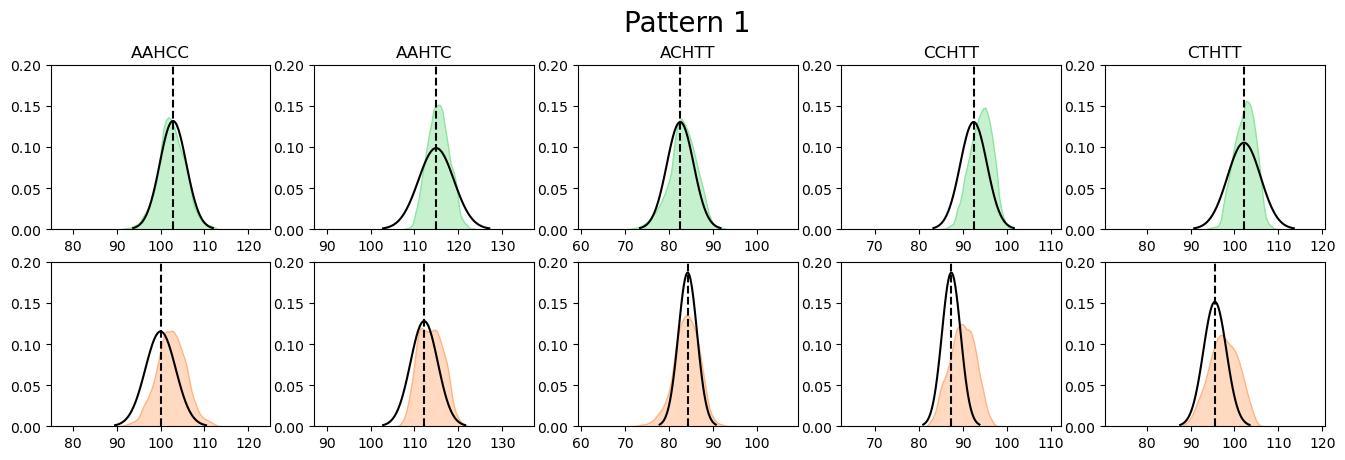

In [6]:
plot_exmaple_kmers(pattern_1_example_kmers, 1)

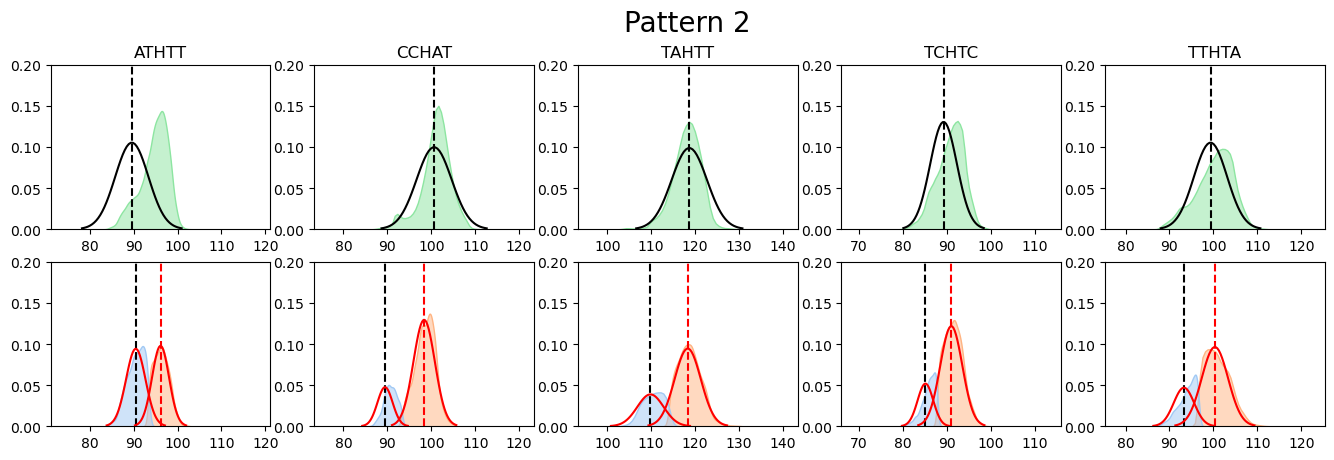

In [7]:
plot_exmaple_kmers(pattern_2_example_kmers, 2)

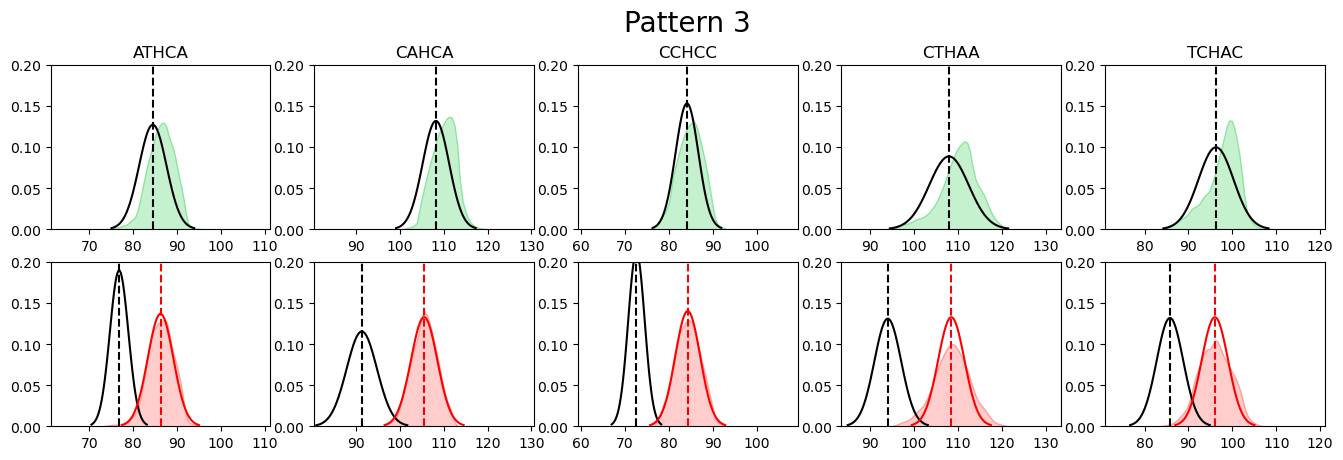

In [8]:
plot_exmaple_kmers(pattern_3_example_kmers, 3)

In [9]:
def plot_box(df, pattern):

    _df = df[df['pattern'] == pattern]
    _A_mean_arr = list(_df['model_mean'])
    _I_mean_arr = list(_df['model_mean_mod'])

    _kmer_arr = list(_df['model_kmer'])
    _kmer_arr = [i[0:2] + "G" + i[3:5] for i in _kmer_arr]

    def set_select(k):
        if k in _kmer_arr:
            return 1
        else:
            return 0
    df['select'] = df['model_kmer'].apply(lambda x: set_select(x))
    _df = df[df['select'] == 1]
    _G_mean_arr = list(_df['model_mean'])

    pal = sns.color_palette("pastel")
    plot_data = [_A_mean_arr, _I_mean_arr, _G_mean_arr]
    bplot = plt.boxplot(plot_data, patch_artist=True)
    # fill with colors
    colors = [pal[0], pal[3], pal[2]]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    plt.xticks([1, 2, 3], ['XXAXX', 'XXIXX', 'XXGXX'])
    plt.suptitle('Pattern ' + str(pattern), fontsize=15)
    plt.show()

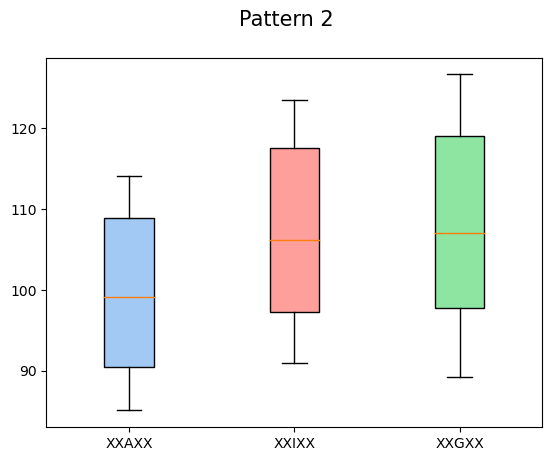

In [10]:
plot_box(model_kmer, 2)

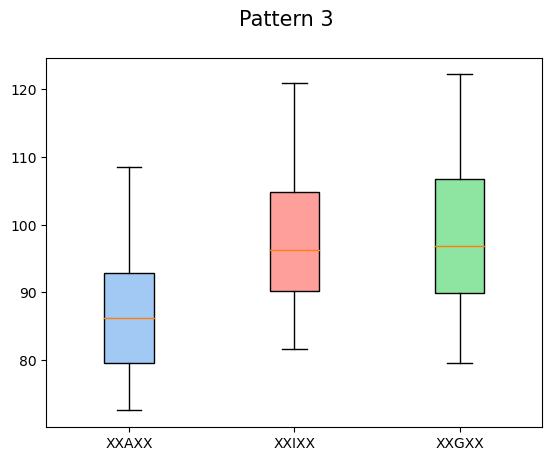

In [11]:
plot_box(model_kmer, 3)

The original publication (Nguyen, T.A. et al. Direct identification of A-to-I editing sites with nanopore native RNA sequencing. Nat Methods 19, 833-844, 2022.) privdes 4,934 genomic locations modfication rate on Chromosome 3 and 11 (https://codeocean.com/capsule/4038948/tree/v1, test_H9_regression_allannotatedsites_0to1.RData).

From these genomic locations, we only select the Pattern 2 and 3 (1,007 sites). And we treat the sites with a modification rate greater than 0.1 as the positive control, and sites with a 
modification rate equal to 0 as the negative control. 

In [12]:
gt_df = pd.read_csv("test_H9_regression_allannotatedsites_0to1_with_kmer_filter.csv")
print(gt_df)

      chr strand   position      rate   kmer  pattern  label
0      11      +  108236520  0.181818  TCACA        3      1
1      11      +  108236590  0.125000  CTACT        3      1
2      11      +  108236593  0.229167  CTAAA        3      1
3      11      +  108236595  0.291667  AAAAA        2      1
4      11      +  108236599  0.100000  ATACA        3      1
...   ...    ...        ...       ...    ...      ...    ...
1002    3      -    9883040  0.000000  CTAAA        3      0
1003    3      -    9883100  0.000000  TCACC        3      0
1004    3      -    9883389  0.000000  TCACT        3      0
1005    3      -    9987687  0.000000  ATACA        3      0
1006    3      -    9987692  0.000000  TAAAA        3      0

[1007 rows x 7 columns]


In [13]:
pos_gt_df = gt_df[gt_df['label'] == 1]
print(f"Postive control: {len(pos_gt_df)} sites.")

neg_gt_df = gt_df[gt_df['label'] == 0]
print(f"Negtive control: {len(neg_gt_df)} sites.")

Postive control: 129 sites.
Negtive control: 878 sites.


We only select 10 samples (Accession: SRX14436756, SRX14436755, SRX14436754, SRX14436753, SRX14436752, SRX14448128, SRX14448125, SRX14448129, SRX14604385, and SRX14604391) from the H9 WT embryo (https://www.ncbi.nlm.nih.gov/sra/?term=SRP363295). After the SegPore workflow using the `model_kmer`, we keep the sites with the read coverage larger than 10.

In [14]:
res_df = pd.read_csv("site_mod_rate_A_to_I.csv")

pos_res_df = res_df[res_df['label'] == 1]
pos_data = list(pos_res_df['pred_wt_rate'])

neg_res_df = res_df[res_df['label'] == 0]
neg_data = list(neg_res_df['pred_wt_rate'])

kmer_list = list(set(list(res_df['kmer'])))
print(f"5mer count: {len(kmer_list)}.")

5mer count: 18.


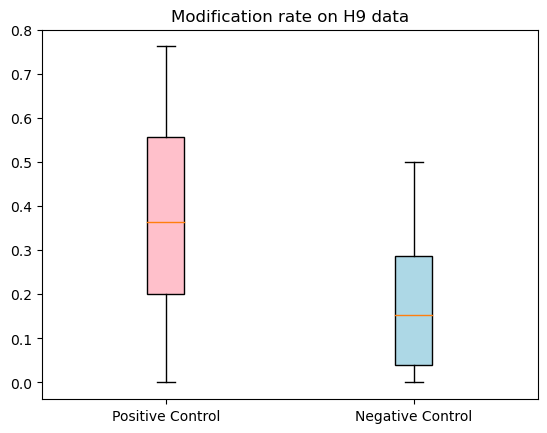

In [15]:
plot_data = [pos_data, neg_data]
bplot = plt.boxplot(plot_data, patch_artist=True)
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1, 2], ['Positive Control', 'Negative Control'])
plt.title('Modification rate on H9 data')
plt.show()

In [16]:
from scipy import stats
print(stats.ttest_ind(pos_data, neg_data, equal_var=True))

Ttest_indResult(statistic=6.978163758809104, pvalue=2.2207800776957728e-11)
